# Causal Machine Learning Tutorial

This is a tutorial in using two different causal machine learning approaches: targeted maximum likelihood estimation (TMLE) and double/debiased machine learning (DML). These methods are both going to be used to estimate the treatment effect for a binary treatment.  
  
This is strongly based on a tutorial given in: https://migariane.github.io/TMLE.nb.html, which implemented TMLE in `R` and https://github.com/matthewvowels1/TargetedLearningTutorial which implemented TMLE on the same problem in `Python`. Here, both are to be implemented in `Python` and we will compare the performance of TMLE and DML.  
  
See the paper here: *Luque-Fernandez MA, Schomaker M, Rachet B, Schnitzer ME. Targeted maximum likelihood estimation for a binary treatment: A tutorial. Statistics in Medicine. 2018; 37: 2530–2546. https://doi.org/10.1002/sim.7628*

In [ ]:
import numpy as np
import pandas as pd

import statsmodels.api as sm
import statsmodels.formula.api as smf # allows R-like syntax 

import networkx as nx 
import matplotlib.pyplot as plt

### Data Generating Function
  
Causal ML is about inferring parameters of some data generating function.
  
A key element is the DAG, we work off the following DAG (taken directly from the paper). This DAG is intended to simulate the causal pathway for mortality from cancer treatment 
  
We then generate date based on that DAG:
- `W1` ('sex') and `W2` ('age category') are generated as Bernoulli variables with probabibility 0.5 and 0.65 respectively 
- `W3` ('cancer stage') and `W4` ('comorbidities') are generated as ordinal variables with 4 and 5 levels respectively. The value for each is generated as a random uniform distribution and the values are rounded off to the closest integer
- `A` ('treatment variable') and `Y` ('outcome variable') are generated as binary indicators using a log-linear model. In the treatment and outcome models, there is an interaction term between `W2` and `W4` based on e.g. 'increased risk of comorbidities among older adults' 

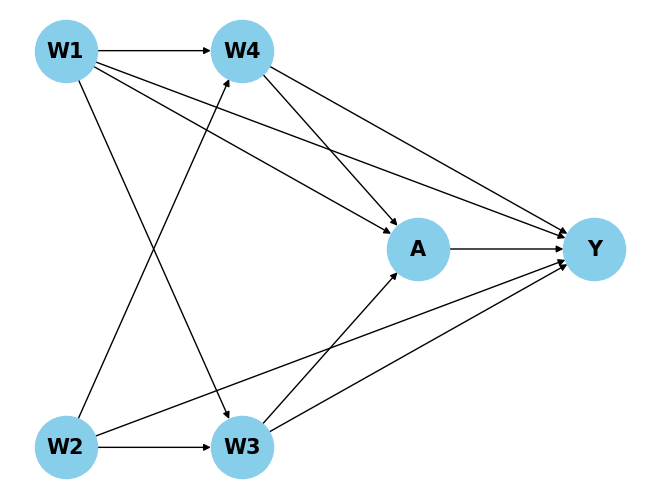

In [2]:
G = nx.DiGraph()
# Add edges
edges = [\
        ('W2', 'W3'), ('W2', 'W4'), ('W2', 'Y'), \
        ('W3', 'A'), ('W3', 'Y'), \
        ('W1', 'W3'), ('W1', 'A'), ('W1', 'Y'), ('W1', 'W4'), \
        ('W4', 'A'), ('W4', 'Y'), \
        ('A', 'Y')]

G.add_edges_from(edges)

# Assign layers for multipartite layout (optional, improves clarity)
for node in G.nodes:
    if ((node == 'W1') or (node == 'W2')):
        G.nodes[node]['layer'] = 0
    elif ((node == 'W3') or (node == 'W4')):
        G.nodes[node]['layer'] = 1
    elif node == 'A':
        G.nodes[node]['layer'] = 2
    elif node == 'Y':
        G.nodes[node]['layer'] = 3

# Use multipartite layout
pos = nx.multipartite_layout(G, subset_key="layer")

nx.draw(G, pos, with_labels=True, node_size=2000, node_color="skyblue", font_size=15, font_color="black", font_weight="bold")
plt.show()

In [3]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

def logit(p):
    return np.log(p) - np.log(1 - p)

def generate_data(n, seed_val):
    np.random.seed(seed_val)
    # randomly initialise comorbidities 
    w1 = np.random.binomial(1, 0.5, n)        
    w2 = np.random.binomial(1, 0.65, n)    
    w3 = np.round(np.random.uniform(0, 4, n), 3)
    w4 = np.round(np.random.uniform(0, 5, n), 3)
    
    # probability of receiving treatment model
    p_A = sigmoid(-5 + 0.05*w2 + 0.25*w3 + 0.6*w4 +0.4*w2*w4)
    # binary outcome based on this calculated probability
    A = np.random.binomial(1, p_A, n)
    
    # probability of outcome models
    p_y1 = sigmoid(-1 + 1 -0.1*w1 + 0.35*w2 + 0.25*w3+ 0.2*w4 + 0.15*w2*w4)
    p_y0 = sigmoid(-1 + 0 -0.1*w1 + 0.35*w2 + 0.25*w3 + 0.2*w4 + 0.15*w2*w4)
    Y1 = np.random.binomial(1, p_y1, n)
    Y0 = np.random.binomial(1, p_y0, n)
    
    # actual observed outcome
    Y = Y1 * A + Y0*(1-A)
    
    cols = ['w1', 'w2', 'w3', 'w4', 'A','Y', 'Y1', 'Y0']
    df = pd.DataFrame([w1, w2, w3, w4, A, Y, Y1, Y0]).T
    df.columns = cols
    return df

In [21]:
df = generate_data(2000000, 555) # generate a huge dataset from which we can calculate the 'true' ATE

In [23]:
true_EY1 = df['Y1'].mean()
true_EY0 = df['Y0'].mean()
true_ATE = true_EY1-true_EY0
print(f'True ATE = {true_ATE}')

True ATE = 0.19324049999999993


In [24]:
# now generate a much smaller dataset that we will actually use for our methods
df = generate_data(10000, 556)

In [68]:
df

,w1,w2,w3,w4,A,Y,Y1,Y0
0,1.0,1.0,3.380,2.750,0.0,1.0,0.0,1.0
1,0.0,0.0,3.994,3.031,0.0,1.0,1.0,1.0
2,1.0,1.0,0.040,4.536,1.0,1.0,1.0,1.0
3,1.0,0.0,2.001,3.052,0.0,1.0,1.0,1.0
4,0.0,0.0,0.007,4.160,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...
9995,0.0,1.0,1.777,2.746,0.0,1.0,1.0,1.0
9996,1.0,1.0,0.777,4.488,1.0,1.0,1.0,1.0
9997,1.0,1.0,1.428,2.478,0.0,0.0,1.0,0.0
9998,0.0,1.0,1.843,1.945,0.0,1.0,0.0,1.0


## TMLE  
  
Here are the steps implementing the TMLE method

In [ ]:
# first, we implement an intentionally wrong model (binary logistic regression, without the interaction terms)

# this is the outcome model, fit a binary logistic regression for it 
model = smf.logit("Y ~ A + w1 + w2 + w3 + w4", data=df)
model = model.fit()

print(model.summary())

Optimization terminated successfully.
         Current function value: 0.607563
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      Y   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9994
Method:                           MLE   Df Model:                            5
Date:                Wed, 20 Nov 2024   Pseudo R-squ.:                 0.08721
Time:                        12:38:13   Log-Likelihood:                -6075.6
converged:                       True   LL-Null:                       -6656.1
Covariance Type:            nonrobust   LLR p-value:                8.525e-249
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.1873      0.070    -16.972      0.000      -1.324      -1.050
A              0.8134      0.

In [35]:
# we create a new dataset where the treatment variables are set to 1 and 0 
newdata_A1 = df.copy()
newdata_A1['A'] = 1

newdata_A0 = df.copy()
newdata_A0['A'] = 0

# predict probabilities based on this data 
QAW = model.predict(df)
Q1W = model.predict(newdata_A1)
Q0W = model.predict(newdata_A0)

# initial ATE estimate: 
init_ATE_est = Q1W.mean() - Q0W.mean()
print(f'Initial (biased) ATE estimate = {init_ATE_est}')

Initial (biased) ATE estimate = 0.16147770596532363


In [ ]:
# this is the treatment model (propensity score) 
ps_model = smf.logit("A ~ w1 + w2 + w3 + w4", data=df)
ps_model = ps_model.fit()
print(ps_model.summary())

Optimization terminated successfully.
         Current function value: 0.335604
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      A   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9995
Method:                           MLE   Df Model:                            4
Date:                Wed, 20 Nov 2024   Pseudo R-squ.:                  0.2144
Time:                        12:40:17   Log-Likelihood:                -3356.0
converged:                       True   LL-Null:                       -4271.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -5.8512      0.143    -40.835      0.000      -6.132      -5.570
w1            -0.0393      0.

In [41]:
# use this model to calculate propensity scores 
gW = ps_model.predict(df)

In [43]:
# summarise propensity score model distribution 
print(gW.describe())

count    10000.000000
mean         0.152600
std          0.159365
min          0.002814
25%          0.030989
50%          0.085153
75%          0.228683
max          0.680824
dtype: float64


In [61]:
# now we use the propensity score to correct the outcome model, by means of the clever covariate

# clever covariates
H1W = df['A']/gW 
H0W = (1 - df['A'])/(1 - gW)
X = pd.DataFrame({'H0W': H0W, 'H1W': H1W})


# fluctuation/substitution parameter 

# convert QAW to logit scale
logit_QAW = np.log(QAW/(1-QAW))

model_epsilon = sm.GLM(df['Y'], X, family=sm.families.Binomial(), offset=logit_QAW)
model_epsilon = model_epsilon.fit()
print(model_epsilon.summary())
print('\n')
print("EPSILON")
epsilon = model_epsilon.params
epsilon

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      Y   No. Observations:                10000
Model:                            GLM   Df Residuals:                     9998
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -6074.6
Date:                Wed, 20 Nov 2024   Deviance:                       12149.
Time:                        12:56:40   Pearson chi2:                 1.00e+04
No. Iterations:                     4   Pseudo R-squ. (CS):          0.0001960
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
H0W            0.0031      0.019      0.161      0.8

H0W    0.003124
H1W    0.004345
dtype: float64

In [64]:
# use the epsilon values to improve the treatment model
epsilon['H0W']

from scipy.special import expit 

# Convert Q0W and Q1W to logit scale and update them
logit_Q0W = np.log(Q0W / (1 - Q0W))
logit_Q1W = np.log(Q1W / (1 - Q1W))

# Update logit values with epsilon adjustments
logit_Q0W_1 = logit_Q0W + epsilon['H0W'] / (1 - gW)
logit_Q1W_1 = logit_Q1W + epsilon['H1W'] / gW

# Convert back to probabilities using inverse-logit
Q0W_1 = expit(logit_Q0W_1)
Q1W_1 = expit(logit_Q1W_1)

In [ ]:
# Now we can calculate an improved ATE
EY1_tmle_1 = Q1W_1.mean()
EY0_tmle_1 = Q0W_1.mean()
ATE_tmle_1 = EY1_tmle_1 - EY0_tmle_1


0.18631804269111385


In [ ]:
# combine all of this info into a new table 
new_df = pd.DataFrame({
    'Q0W': Q0W,
    'Q1W': Q1W,
    'gW': gW,
    'Q0W_1': Q0W_1,
    'Q1W_1': Q1W_1,
    'Q1W_1 - Q0W_1': Q1W_1 - Q0W_1
})

# Set the index of the new DataFrame to match the index of the original df (patient id)
new_df.index = df.index

new_df

In [74]:
# compare ATE estimate (corrected) to naive ATE and true estimate
print("="*50)
print(f'Initial (uncorrected) ATE estimate = {init_ATE_est}')
print(f'Absolute bias (from true value) = {abs(init_ATE_est-true_ATE)}')
print(f'Percentage bias (from true value) = {abs(init_ATE_est-true_ATE)*100/true_ATE}%')
print("="*50)
print(f'Corrected (by TMLE) ATE estimate = {ATE_tmle_1}')
print(f'Absolute bias (from true value) = {abs(ATE_tmle_1-true_ATE)}')
print(f'Percentage bias (from true value) = {abs(ATE_tmle_1-true_ATE)*100/true_ATE}%')
print("="*50)


Initial (uncorrected) ATE estimate = 0.16147770596532363
Absolute bias (from true value) = 0.0317627940346763
Percentage bias (from true value) = 16.43692395469703%
Corrected (by TMLE) ATE estimate = 0.18631804269111385
Absolute bias (from true value) = 0.006922457308886076
Percentage bias (from true value) = 3.5823014890181297%


In [ ]:
# what if we use ML and a superlearner to try to avoid model misspecification